# Objectives
FISH analysis:
 - Ground truth data for spot locations is generally difficult to get.
 - Spot locations can be quite apparent to the human eye. 
 - **Hypothesis**: We may be able to crowdsource annotations for these images from workers through Amazon Turk to arrive at consensus ground truth annotations.

**My goal**: Develop the piece of the pipeline that takes us from these crowdsourced annotations to a consensus.

<img src="files/ISP_AnnotationAnalysisPipeline-01.png">

This notebook provides a few examples of analyses that can be performed with the SpotAnnotationAnalysis class as it is now. New analysis methods will continually be added to this class.

# The BaseAnnotation class
The BaseAnnotation class abstracts the nuts and bolts of ingesting crowdsourced annotations.

### Methods
 - init
     - Description: Constructor. Imports annotations to a dataframe and saves the dataframe
	as a property of the BaseAnnotation class
     - Input: name of json file with annotation data.
     - Returns: none
 - import_annotations
     - Description: Abstract method overwritten by child classes, such as QuantiusAnnotation. Raises an error if the method has not been overwritten by a child class.
 - df
     - Description: provides access to the QuantiusAnnotation object's dataframe
     - Input: none
     - Returns: entire pandas dataframe object
 - print_head
     - Description: prints the first five lines of a dataframe
     - Input: a dataframe
     - Returns: none     
 - get_workers
     - Description: provides access to the worker names in the QuantiusAnnotation object
     - Input: a dataframe
     - Returns: list of unique UIDs of workers (as strings)
 - get_images
     - Description: provides access to the image names in the QuantiusAnnotation object
     - Input: a dataframe
     - Returns: list of unique image names (as strings)
 - get_timestamps
     - Description: provides access to the timestamps for a worker's annotations
     - Input: a dataframe, the worker's UID
     - Returns: list of that worker's timestamps
 - slice_by_image
     - Description: expedites slicing of a dataframe by image
     - Input: a dataframe, the filename of a cropping
     - Returns: a dataframe with only annotations containing that cropping 
 - slice_by_worker
     - Description: expedites slicing of a dataframe by image
     - Input: a dataframe, the UID of a worker
     - Returns: a dataframe with only annotations by that turker
 - get_coords
     - Description: provides access to all coordinates in a dataframe
     - Input: a dataframe
     - Returns: a numpy array with all the coordinates in the dataframe   
 - flip
     - Description: flips the values of a list about a height. Useful for flipping y axis for plotting over an image.
     - Input: a list of values, the height of the y axis
     - Returns: the values flipped about the height
 - get_avg_time_per_click
     - Description: calculates the average time that a worker spent per click
     - Input: the worker's UID
     - Returns: float avg time that the worker spent per click
 - get_total_time
     - Description: calculates the total time that a worker spent from first to last click
     - Inputs: a dataframe, the worker's UID
     - Returns: total time that the worker spent from first to last click
     
# The QuantiusAnnotation class
The QuantiusAnnotation class inherits from the BaseAnnotation class and implements import_annotations for data from Quantius.

 - import_annotations
     - Description: implementation for data from Quantius, overwrites the abstract method in BaseAnnotation.

# The SpotAnnotationAnalysis class
The SpotAnnotationAnalysis class provides higher-level annotation analysis tools. SpotAnnotationAnalysis takes in a BaseAnnotation object as an input and saves it as a property of the class.

### Class variables
 - clustering_algs - a list of strings representing clustering algorithms supported by the class
 - colors - a list of strings giving the hex numbers for the colors associated with the turkers
 
### Methods
  - init
     - Description: Constructor. Takes in a BaseAnnotation object and saves it as a property of the SpotAnnotationAnalysis class.
  - get_clusters
     - Description: Clusters annotation data and organizes cluster location and member data.
     - Inputs:
         - string name of the clustering algorithm to use
         - pandas dataframe with annotation data (should already be cropped)
         - list of parameters used by the clustering algorithm
     - Returns:
         - this dataframe: centroid_x | centroid_y | members
			- the index is the Cluster ID
			- centroid_x = x coord of cluster centroid
			- centroid_y = y coord of cluster centroid
			- members = list of annotations belonging to the cluster    
  - anno_and_ref_to_df
     - Description: Organizes cluster and nearest neighbor data for a given set of annotations.
     - Inputs:
		 - string name of clustering alg to use
		 - df with annotation data (should already be cropped)
		 - list of clustering params for clustering alg
		 - csv_filename (contains reference data)
		 - img_filename (the cropping)
     - Returns:
         - this dataframe: centroid_x | centroid_y | x of nearest ref | y of nearest ref | NN_dist | members
			- the index is the Cluster ID
			- centroid_x = x coord of cluster centroid
			- centroid_y = y coord of cluster centroid
			- NN_x = x coord of nearest neighbor reference
			- NN_y = y coord of nearest neighbor reference
			- NN_dist = distance from centroid to nearest neighbor reference
			- members = list of coordinates of annotations belonging to cluster
  - get_cluster_correctness
     - Description: Calculates and organizes correctness data for a given set of cluster data and a threshold.
     - Inputs:
         - df in this form: centroid_x | centroid_y | x of nearest ref | y of nearest ref | NN_dist | members
			- the index is the Centroid ID
		 - int threshold
			- for each centroid, if NN_dist <= threshold, centroid is "correct"
     - Returns:
         - 2-column array with a row for each centroid
			- column 0 = Centroid ID
			- column 1 = True if centroid is "correct", False if centroid is "incorrect"
  - csv_to_kdt
     - Description: Formats data in csv as a kd-tree for fast searching. 
     - Inputs:
         - string csv_filename with reference data
     - Returns: 
         - kd-tree with reference data flipped vertically
  - calc_distances
     - Description: Finds nearest neighbor distances for all annotations from all workers. 
     - Inputs:
         - pandas dataframe
         - kd-tree with reference data
         - string img_filename (the only cropping to include)
     - Returns: 
         - List containing one list for each worker. Each list is comprised of, for each of the turker's points, the distance to the nearest neighbor (found in the k-d tree of references).        
  - calc_time_per_click
     - Description: Formats data in csv as a kd-tree for fast searching. 
     - Inputs:
         - pandas dataframe
         - string img_filename (the only cropping to include)
     - Returns: 
         - list containing one list for each worker with time spent on each click
	 - Notes:
         - Time spent on click_k = timestamp_k - timestamp_(k-1)
		 - Starts at index 1 of returned list. (Length of times_spent is same as length of timestamps.)
  - plot_annotations
     - Description: Quick visualization of worker annotations, clusters, and/or annotation and cluster "correctness."
     - Inputs:
		 - pandas df with annotation data
		 - string img_filename to crop to
		 - string csv_filename with reference data
		 - int size of worker marker
		 - int size of cluster centroid marker
         - bool whether to plot reference annotations
		 - bool whether to plot workers
		 - bool whether to plot cluster centroids
		 - bool whether to color worker markers green/magenta to indicate "correctness"
		 - bool whether to color centroid markers green/magenta to indicate "correctness"
         - bool whether to color each incorrect cluster's nearest neighbor the same color as the incorrect cluster
		 - int threshold distance from centroid to the nearest reference annotation beyond which the entire cluster is "incorrect"
		 - string name of clustering algorithm
		 - list of clustering parameters
         - bool whether to use a bigger window size (for jupyter notebook)
     - Returns: none  
  - plot_avg_time_per_click
     - Description: Plots the average time spent per click for all workers in the dataframe.
     - Input: 
         - pandas dataframe
         - bool whether to use a bigger window size (for jupyter notebook)
     - Returns: none 
  - plot_nnd_vs_time_spent
     - Description: For each annotation (each click) in a dataframe, plot nearest neighbor distance (nnd) vs. time spent. Each point represents one annotation (one click). All workers on one plot, colored by worker ID. Can color each point by correctness. 
     - Input: 
         - pandas dataframe
         - string img_filename (the only cropping to include)
         - string csv_filename with reference data
         - bool whether to color each point by correctness of cluster
     - Returns: none 
  - plot_nnd_vs_worker_index  
     - Description: For each annotation (each click) in a dataframe, plot nearest neighbor distance (nnd) vs. worker index. Each point represents one annotation (one click). 
     - Input: 
         - pandas dataframe
         - string img_filename (the only cropping to include)
         - string csv_filename with reference data
     - Returns: none 
  - plot_time_spent_vs_worker_index  
     - Description: For each annotation (each click) in a dataframe, plot nearest neighbor distance (nnd) vs. worker index. Each point represents one annotation (one click). 
     - Input: 
         - pandas dataframe
         - string img_filename (the only cropping to include)
     - Returns: none
  - plot_total_time_vs_worker_index
     - Description: For each worker, plot total time spent vs. worker index. Each bar represents one worker. 
     - Input: 
         - pandas dataframe
         - string img_filename (the only cropping to include)
     - Returns: none
  - plot_time_spent_vs_click_index  
     - Description: For one worker in a dataframe, plot time spent on click vs. index of that click. Each point represents one annotation (one click).
     - Input: 
         - pandas dataframe
         - string img_filename (the only cropping to include)
         - string uid (worker ID)
     - Returns: none
     
## Structure of the annotation dataframe
(Copied and pasted from Kevin's BeadAnnotation_20180413 notebook)

The annotated images are crops of an image of fluorescence image of 100 nm fluorescent beads embedded in mouse lung tissue. The images were acquired on a widefield epifluorescence microscope with a 40x 1.10 NA water immersion objective (pixels are 162.5 x 162. nm^2 in the sample plane). The image was annotated by 20 people on Mechanical Turk via Quantius. The data are imported via the function importAnnotations() into a Pandas DataFrame with the following columns:

### annotation dataframe columns (each row is an annotation):

 - timestamp - this is a timestamp for the annotation, but I am unsure of the units - need to discuss with Quantius
 - x - the x-coordinate of the annotation
 - y - the y-coordinate of the annotation
 - annotation_type - the type of annotation that was requested. "crosshair" is used for point selection.
 - height - height of the image in pixels
 - width - width of the image in pixels
 - image_filename - filename of the image that was annotated
     - There were 5 images annoated. They are all crops (aligned in the upper left hand corner) of the same image to assess the effect of number of objects on Turker performance
     - The images are located in the "Crops" subdirectory and named "beads_(crop size)pxroi.png"
 - time_when_completed - time when the worker finished annotating the image
 - worker_id - unique identifier for the worker that performed the annotation

In [1]:
from SpotAnnotationAnalysis import SpotAnnotationAnalysis
from BaseAnnotation import BaseAnnotation
from QuantiusAnnotation import QuantiusAnnotation

In [2]:
img_filename = 'beads_300pxroi.png'
json_filename = 'BeadAnnotation_20180413.json'
csv_filename = 'bead_annotations_20180517_shifted.csv'
worker_marker_size = 8
cluster_marker_size = 40
bigger_window_size = False

### Load data, get the dataframe 

In [3]:
ba = QuantiusAnnotation(json_filename)	# Load data into an annotation object
sa = SpotAnnotationAnalysis(ba)			# Annotation object is saved as a property of a SpotAnnotationAnalysis object
anno_all = ba.df()						# Get the dataframe from the annotation object

# Plot to get an overview of annotations. 
The plot_annotations method plots all coordinates for all workers for one cropping. It is a versatile way to get a "quick look" at the data.

### Example 1: Plot worker annotations only.

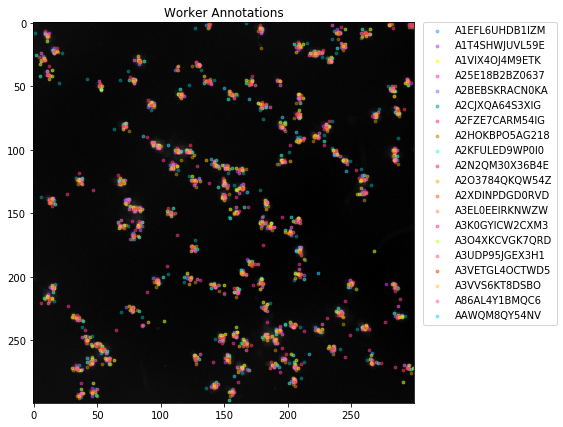

In [4]:
show_ref_points = False
show_workers = True
show_clusters = False
clustering_params = None
show_correctness_workers = False
show_correctness_clusters = False
show_NN_inc = False
correctness_threshold = None

sa.plot_annotations(anno_all, img_filename, csv_filename, worker_marker_size, cluster_marker_size, show_ref_points, show_workers, show_clusters, show_correctness_workers, show_correctness_clusters, show_NN_inc, correctness_threshold, clustering_params, bigger_window_size)

#### Show reference points (big yellow dots).

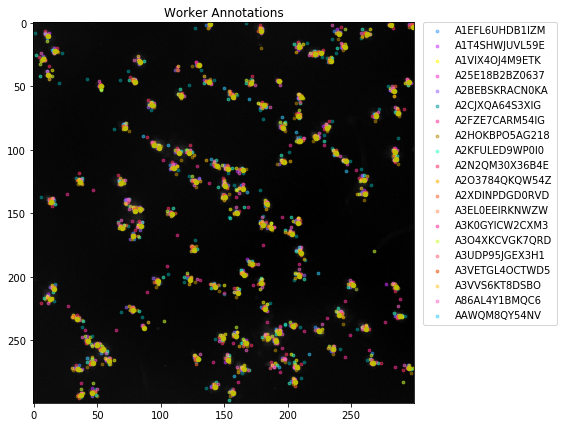

In [5]:
show_ref_points = True
show_workers = True
show_clusters = False
clustering_params = None
show_correctness_workers = False
show_correctness_clusters = False
show_NN_inc = False
correctness_threshold = None

sa.plot_annotations(anno_all, img_filename, csv_filename, worker_marker_size, cluster_marker_size, show_ref_points, show_workers, show_clusters, show_correctness_workers, show_correctness_clusters, show_NN_inc, correctness_threshold, clustering_params, bigger_window_size)

### Example 2: Plot worker annotations and cluster centroids.

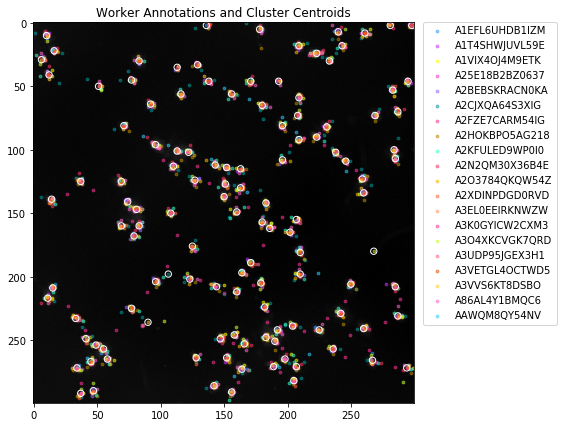

In [6]:
show_ref_points = False
show_workers = True
show_clusters = True
clustering_params = ['AffinityPropagation', -350]
show_correctness_workers = False
show_correctness_clusters = False
show_NN_inc = False
correctness_threshold = None

sa.plot_annotations(anno_all, img_filename, csv_filename, worker_marker_size, cluster_marker_size, show_ref_points, show_workers, show_clusters, show_correctness_workers, show_correctness_clusters, show_NN_inc, correctness_threshold, clustering_params, bigger_window_size)

### Example 3: Plot to visualize correctness.
For each centroid, the nearest neighbor distance to reference data is compared with a given threshold value to determine the "correctness" of the cluster and its members. plot_annotations() provides various ways to visualize this.

#### Example 3.1
Color worker annotations based on membership to correct or incorrect clusters without coloring cluster markers. Toggle correctness_threshold.

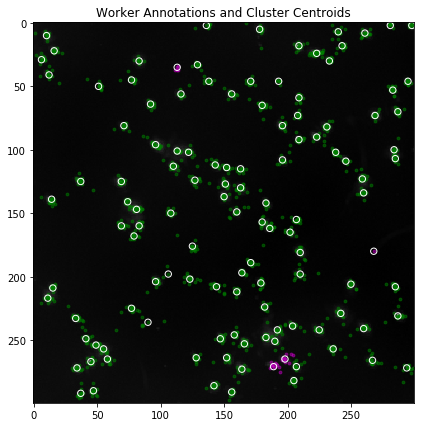

In [7]:
show_ref_points = False
show_workers = True
show_clusters = True
clustering_params = ['AffinityPropagation', -350]
show_correctness_workers = True
show_correctness_clusters = False
show_NN_inc = False
correctness_threshold = 10

sa.plot_annotations(anno_all, img_filename, csv_filename, worker_marker_size, cluster_marker_size, show_ref_points, show_workers, show_clusters, show_correctness_workers, show_correctness_clusters, show_NN_inc, correctness_threshold, clustering_params, bigger_window_size)

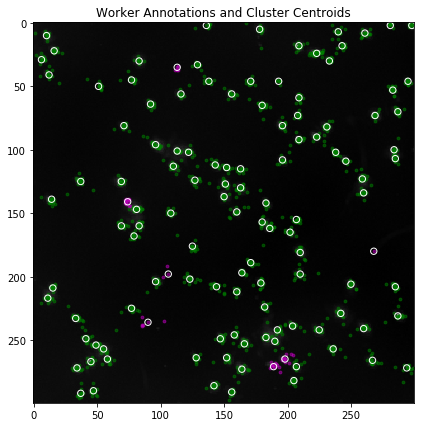

In [8]:
show_ref_points = False
show_workers = True
show_clusters = True
clustering_params = ['AffinityPropagation', -350]
show_correctness_workers = True
show_correctness_clusters = False
show_NN_inc = False
correctness_threshold = 4

sa.plot_annotations(anno_all, img_filename, csv_filename, worker_marker_size, cluster_marker_size, show_ref_points, show_workers, show_clusters, show_correctness_workers, show_correctness_clusters, show_NN_inc, correctness_threshold, clustering_params, bigger_window_size)

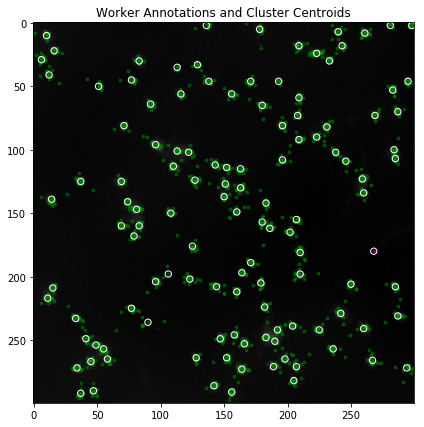

In [9]:
show_ref_points = False
show_workers = True
show_clusters = True
clustering_params = ['AffinityPropagation', -350]
show_correctness_workers = True
show_correctness_clusters = False
show_NN_inc = False
correctness_threshold = 20

sa.plot_annotations(anno_all, img_filename, csv_filename, worker_marker_size, cluster_marker_size, show_ref_points, show_workers, show_clusters, show_correctness_workers, show_correctness_clusters, show_NN_inc, correctness_threshold, clustering_params, bigger_window_size)

#### Example 3.2
Show reference points with cluster correctness.

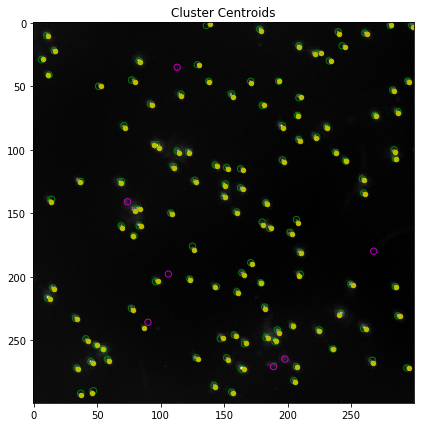

In [10]:
show_ref_points = True
show_workers = False
show_clusters = True
clustering_params = ['AffinityPropagation', -350]
show_correctness_workers = False
show_correctness_clusters = True
show_NN_inc = False
correctness_threshold = 4

sa.plot_annotations(anno_all, img_filename, csv_filename, worker_marker_size, cluster_marker_size, show_ref_points, show_workers, show_clusters, show_correctness_workers, show_correctness_clusters, show_NN_inc, correctness_threshold, clustering_params, bigger_window_size)

#### Example 3.3
For all incorrect clusters, show the nearest neighbor in the same color. (Primary usefulness for now is debugging.)

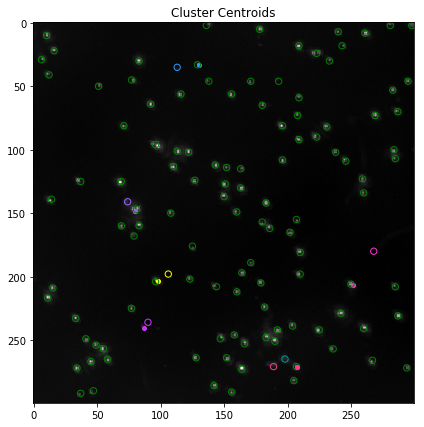

In [11]:
show_ref_points = False
show_workers = False
show_clusters = True
clustering_params = ['AffinityPropagation', -350]
show_correctness_workers = False
show_correctness_clusters = True
show_NN_inc = True
correctness_threshold = 4

sa.plot_annotations(anno_all, img_filename, csv_filename, worker_marker_size, cluster_marker_size, show_ref_points, show_workers, show_clusters, show_correctness_workers, show_correctness_clusters, show_NN_inc, correctness_threshold, clustering_params, bigger_window_size)

### Note: Optimizing parameters.
The architecture of this method makes it easy to toggle and identify optimal quantities such as clustering parameters. The above clusters were generated with -350 as the preference parameter for AffinityPropagation. I was originally clustering with -100 as the preference parameter, and realized that centroids plotted in plot_annotations were showing up in places where there were no annotations at all.

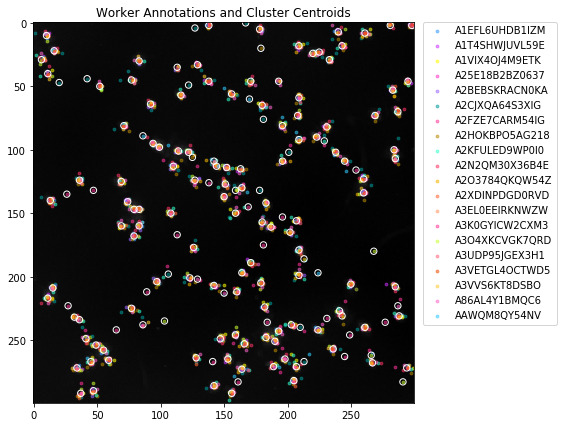

In [12]:
show_ref_points = False
show_workers = True
show_clusters = True
clustering_params = ['AffinityPropagation', -100]
show_correctness_workers = False
show_correctness_clusters = False
show_NN_inc = False
correctness_threshold = None

sa.plot_annotations(anno_all, img_filename, csv_filename, worker_marker_size, cluster_marker_size, show_ref_points, show_workers, show_clusters, show_correctness_workers, show_correctness_clusters, show_NN_inc, correctness_threshold, clustering_params, bigger_window_size)

So I adjusted the clustering paramenter from -100 to -350, which seems to be the sweet spot. At -400, more excess centroids begin showing up again:

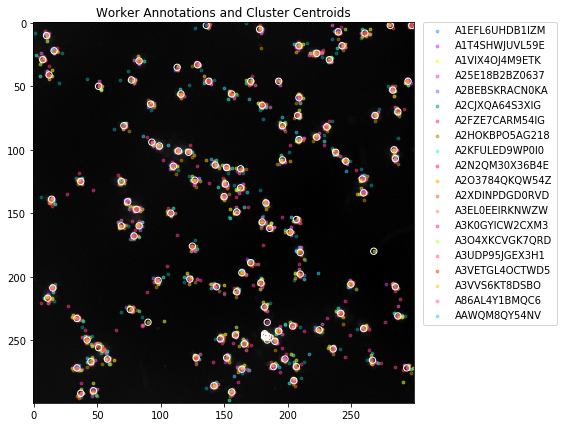

In [13]:
show_ref_points = False
show_workers = True
show_clusters = True
clustering_params = ['AffinityPropagation', -400]
show_correctness_workers = False
show_correctness_clusters = False
show_NN_inc = False
correctness_threshold = None

sa.plot_annotations(anno_all, img_filename, csv_filename, worker_marker_size, cluster_marker_size, show_ref_points, show_workers, show_clusters, show_correctness_workers, show_correctness_clusters, show_NN_inc, correctness_threshold, clustering_params, bigger_window_size)

# Plot to investigate worker efficiency 
As another way to get a "quick look" at the dataset and provide some initial quality control if, for example, a lot of workers are clicking unusually quickly or slowly (for some definition of "unusual"), we can the average time spent per click for all workers in the QuantiusAnnotation object.

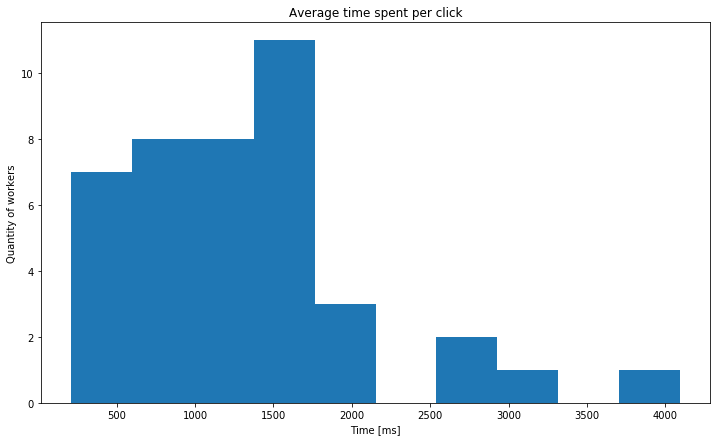

In [14]:
bigger_window_size = False
sa.plot_avg_time_per_click(anno_all, bigger_window_size)
bigger_window_size = True

#### Takeaways:
Most workers spend 1.5 seconds or fewer per click on average.

# Plot to investigate accuracy and speed.
Across clicks, investigate the relationship between accuracy (measured as distance from the click to the nearest neighbor) and speed (measured as the difference between the click's timestamp and the previous click's timestamp).

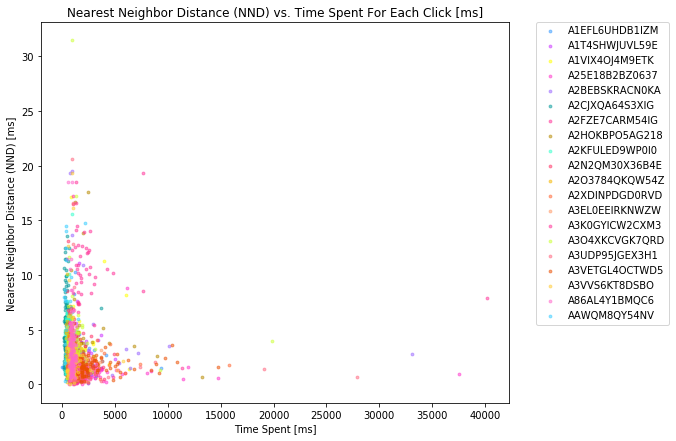

In [15]:
show_correctness = False
correctness_threshold = None
clustering_params = None
sa.plot_nnd_vs_time_spent(anno_all, img_filename, csv_filename, show_correctness, correctness_threshold, clustering_params)

#### Takeaways:

Up until about 2.5 seconds, for any amount of time spent, there are still points far from near neighbors.

Workers that tend to take more time (e.g. 1-2 seconds vs. 0-1 seconds) also tend to have smaller nearest neighbor distances for each click.

#### Color each point (each click) according to the correctness of the cluster of which it is a member:

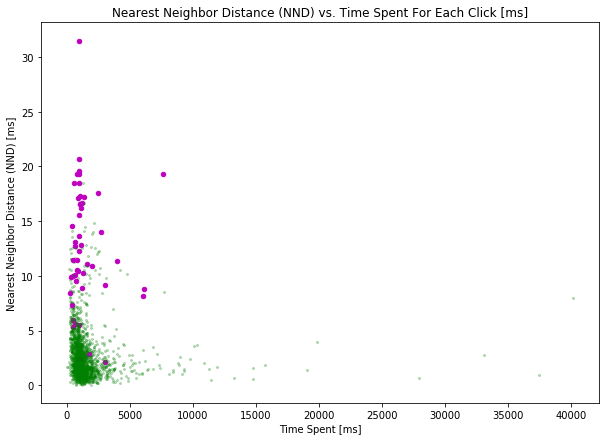

In [16]:
show_correctness = True
correctness_threshold = 4
clustering_params = ['AffinityPropagation', -350]
sa.plot_nnd_vs_time_spent(anno_all, img_filename, csv_filename, show_correctness, correctness_threshold, clustering_params)

#### Takeaways:

Some clicks that get associated with incorrect clusters are actually close to reference points.  So some clicks that are quite “good” are being pulled into clusters that are bad. I think we can see this happening in Example 3.1, second image, near (70,150).


# Plot to compare accuracy between workers.
Compare accuracy (measured as distance from the click to the nearest neighbor) between different workers in a dataframe.

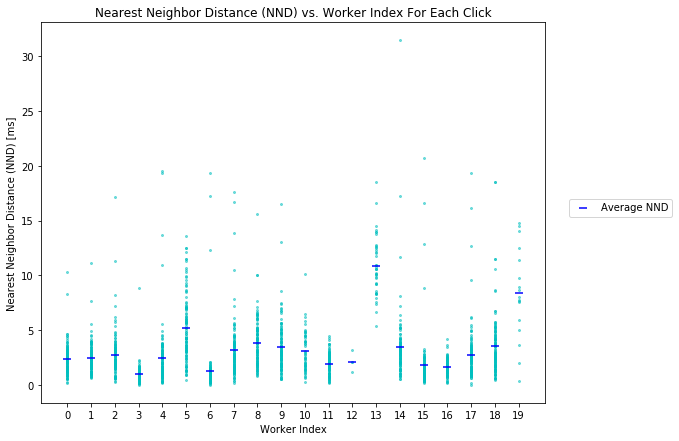

In [17]:
show_correctness = False
correctness_threshold = None
clustering_params = None
show_avgs = True
sa.plot_nnd_vs_worker_index(anno_all, img_filename, csv_filename, show_correctness, correctness_threshold, clustering_params, show_avgs)

#### Takeaways:

While most workers produce some clicks that are quite far from any reference points (in Example 2, the points most loosely associated with any clusters (“floating in space”) seem to come in all colors), some workers are markedly less accurate (e.g. 13, 19, maybe 5).

#### Color each point (each click) according to the correctness of the cluster of which it is a member:

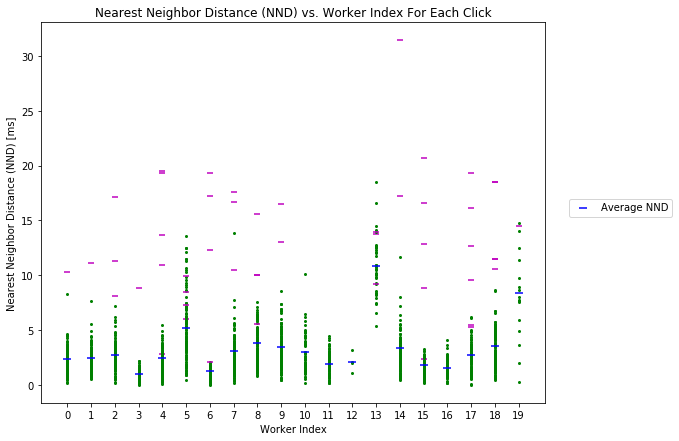

In [18]:
show_correctness = True
correctness_threshold = 4
clustering_params = ['AffinityPropagation', -350]
show_avgs = True
sa.plot_nnd_vs_worker_index(anno_all, img_filename, csv_filename, show_correctness, correctness_threshold, clustering_params, show_avgs)

#### Takeaways:

Some workers’ pretty-good clicks are getting associated with incorrect clusters (i.e. pink markers found among green markers). This issue more severely affects workers who are less accurate (e.g. 5 and 13), although it also affects workers who are very accurate, including 6 and 15.

# Plot to compare speed between workers.
Compare speed (measured as the difference between the click's timestamp and the previous click's timestamp) between different workers in a dataframe.

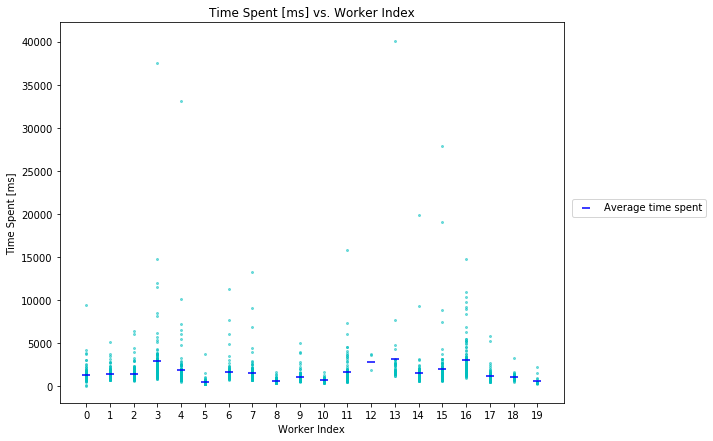

In [19]:
show_correctness = False
correctness_threshold = None
clustering_params = None
show_avgs = True
sa.plot_time_spent_vs_worker_index(anno_all, img_filename, csv_filename, show_correctness, correctness_threshold, clustering_params, show_avgs)

#### Takeaways:

While about a third of the workers have several clicks that take more than 20 seconds, some workers show more of a spread in terms of time spent per click (e.g. 3, 16), and some workers whiz through all their clicks and don’t take a long time on any of them.

I can think of two reasons a click might take an unusually long time:
 - The worker is taking a break from the task.
 - The worker has finished a quick first pass and is now combing through for missed spots.  

The examples shown under the header “Plot to investigate the evolution of a worker's speed” (further along in this notebook) do not seem to support the second possible reason.

#### Color each point (each click) according to the correctness of the cluster of which it is a member:

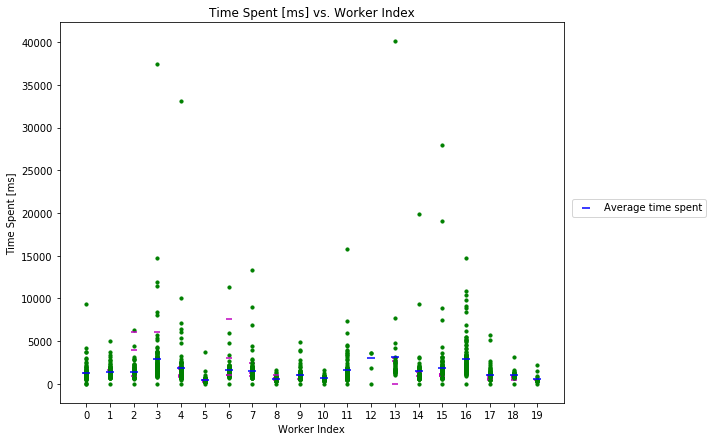

In [20]:
show_correctness = True
correctness_threshold = 4
clustering_params = ['AffinityPropagation', -350]
show_avgs = True
sa.plot_time_spent_vs_worker_index(anno_all, img_filename, csv_filename, show_correctness, correctness_threshold, clustering_params, show_avgs)

#### Takeaways:

For all workers, no clicks that take longer than about 8 seconds are incorrect. Some workers tend to be incorrect when they are clicking more quickly than their average (e.g. 15, 17, 18) while other workers do not follow any discernible pattern with regard to accuracy and time taken to click (e.g. 2, 6).

#### Turn off show_avgs:

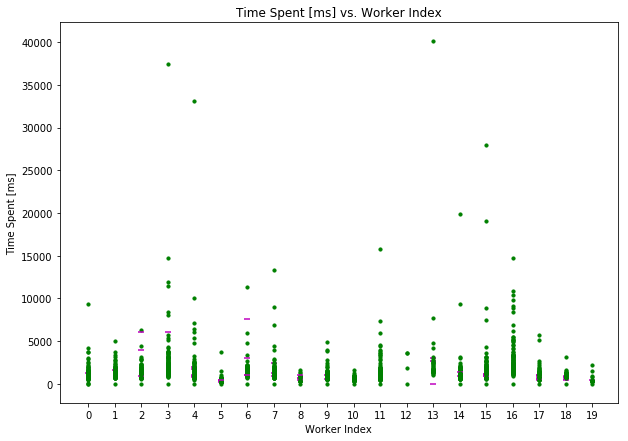

In [21]:
show_correctness = True
correctness_threshold = 4
clustering_params = ['AffinityPropagation', -350]
show_avgs = False
sa.plot_time_spent_vs_worker_index(anno_all, img_filename, csv_filename, show_correctness, correctness_threshold, clustering_params, show_avgs)

# Plot to investigate the total time each worker spends.
For each worker, plot total time spent (defined as the difference between the max timestamp and the min timestamp) vs. worker index. Each bar represents one worker.

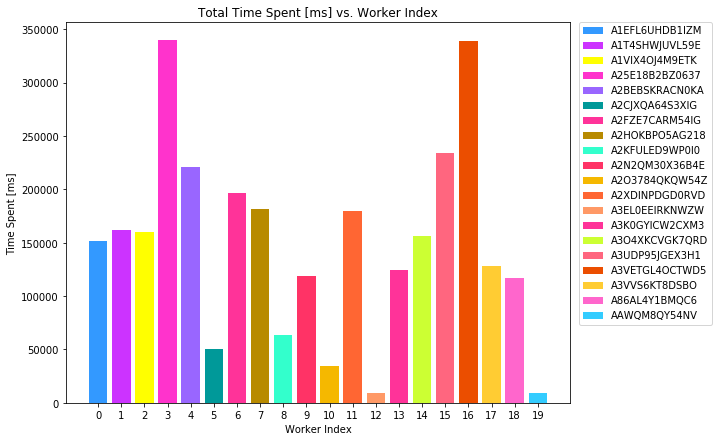

In [22]:
sa.plot_total_time_vs_worker_index(anno_all, img_filename)

#### Takeaways:
The amount of time workers spend in one sitting is highly variable.

# Plot to investigate the evolution of a worker's speed.
Plot the worker's speed (measured as the difference between the click's timestamp and the previous click's timestamp) for each consecutive click.

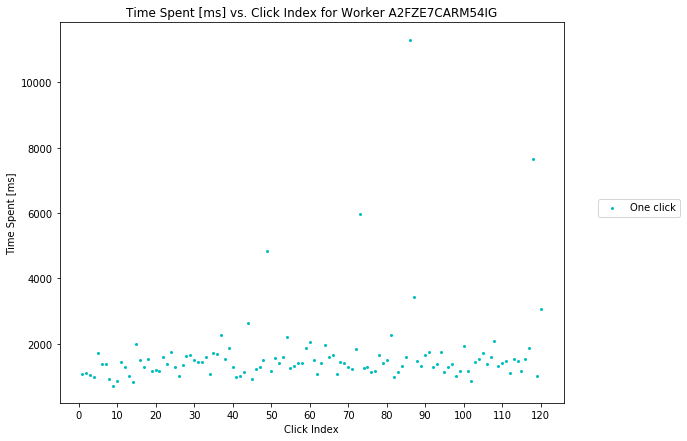

In [23]:
uid = 'A2FZE7CARM54IG'
show_correctness = False
correctness_threshold = None
clustering_params = None

sa.plot_time_spent_vs_click_index(anno_all, img_filename, csv_filename, uid, show_correctness, correctness_threshold, clustering_params)

#### Takeaways:

As mentioned in the discussion about time spent and accuracy under the plot of Time Spent vs. Worker Index, the workers observed in these plots for Time Spent vs. Click Index do not seem to spend much more time toward the end (“combing through after a first pass”).

#### Takeaways from the next five plots:

I was interested in the evolution of time spent and inaccuracy for each worker across click indices. From at this sample of five workers, no pattern seems to be discernible.

#### Color each point (each click) according to the correctness of the cluster of which it is a member:

Here's a randomly selected worker.

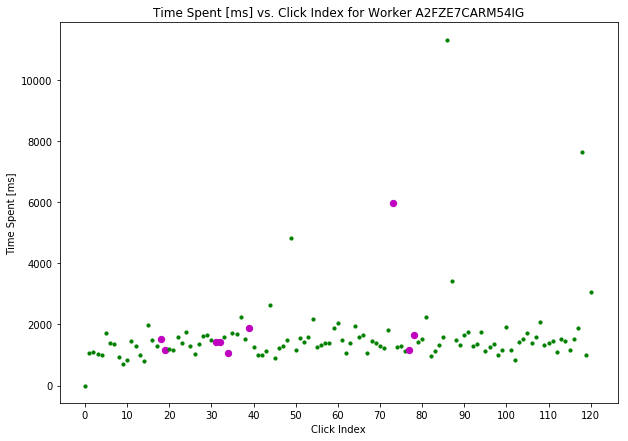

In [24]:
uid = 'A2FZE7CARM54IG'
show_correctness = True
correctness_threshold = 4
clustering_params = ['AffinityPropagation', -350]

sa.plot_time_spent_vs_click_index(anno_all, img_filename, csv_filename, uid, show_correctness, correctness_threshold, clustering_params)

Here's a second randomly selected worker.

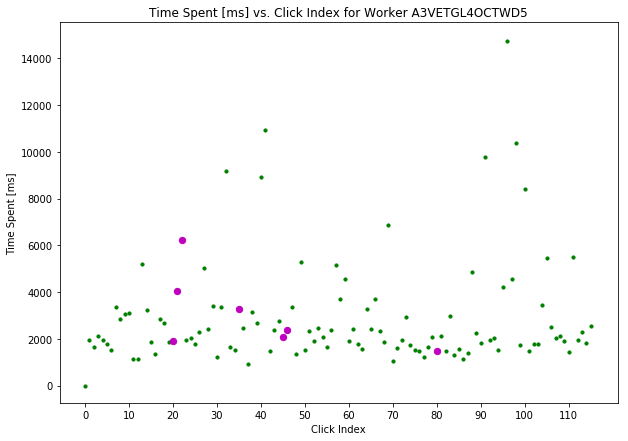

In [25]:
uid = 'A3VETGL4OCTWD5'
show_correctness = True
correctness_threshold = 4
clustering_params = ['AffinityPropagation', -350]

sa.plot_time_spent_vs_click_index(anno_all, img_filename, csv_filename, uid, show_correctness, correctness_threshold, clustering_params)

Here's a third randomly selected worker.

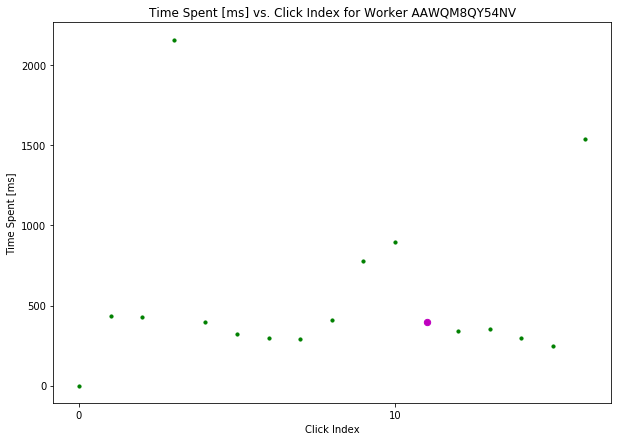

In [26]:
uid = 'AAWQM8QY54NV'
show_correctness = True
correctness_threshold = 4
clustering_params = ['AffinityPropagation', -350]

sa.plot_time_spent_vs_click_index(anno_all, img_filename, csv_filename, uid, show_correctness, correctness_threshold, clustering_params)

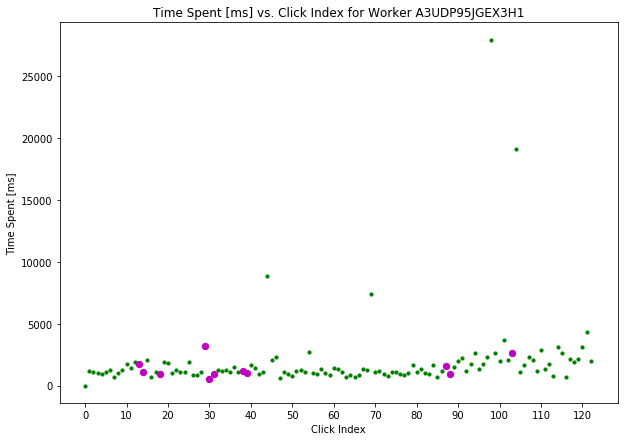

In [27]:
uid = 'A3UDP95JGEX3H1'
show_correctness = True
correctness_threshold = 4
clustering_params = ['AffinityPropagation', -350]

sa.plot_time_spent_vs_click_index(anno_all, img_filename, csv_filename, uid, show_correctness, correctness_threshold, clustering_params)

Here's a fifth worker, not randomly selected. Index 13. Individual clicks of this worker further from nearest neighbor reference points than other workers (see NND vs. Worker Index plot).

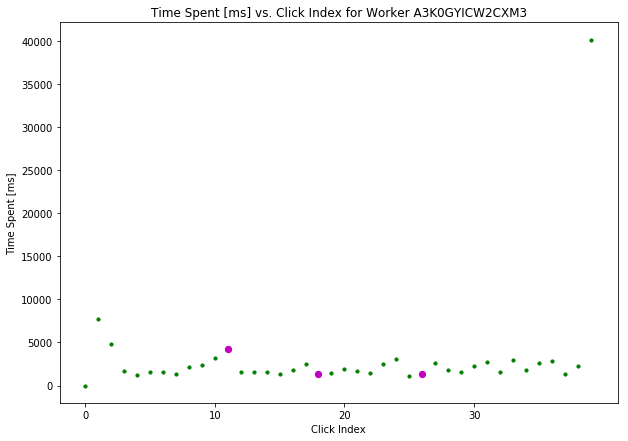

In [28]:
uid = 'A3K0GYICW2CXM3'
show_correctness = True
correctness_threshold = 4
clustering_params = ['AffinityPropagation', -350]

sa.plot_time_spent_vs_click_index(anno_all, img_filename, csv_filename, uid, show_correctness, correctness_threshold, clustering_params)